In [1]:
!nvidia-smi

Mon Mar 25 00:40:06 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.161.07             Driver Version: 535.161.07   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA GeForce MX150           On  | 00000000:01:00.0 Off |                  N/A |
| N/A   51C    P8              N/A / ERR! |     84MiB /  2048MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [2]:
import torch
import torch.nn as nn

torch.cuda.get_device_name(0)

'NVIDIA GeForce MX150'

In [3]:
torch.cuda.is_available()

True

In [4]:
torch.get_num_threads()

4

In [1]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt

### Exp 1

In [37]:
# define sinus function
def sinus_function(x):
    return np.sin(x)

def sin_cos_function(x):
    return np.sin(x) + np.cos(x)

def sin2x_function(x):
    return np.sin(2*x)

def my_function(x):
    return 2*np.sin(x) + 3*np.cos(2*x)

In [25]:
class RNN(nn.Module):
    def __init__(self, batch_size, input_size, hidden_size, num_layers, output_size):
        super(RNN, self).__init__()
        self.batch_size = batch_size
        self.input_size = input_size
        self.hidden_size = hidden_size 
        self.num_layers = num_layers
        self.output_size = output_size

        self.h0 = self.init_hidden()

        self.rnn = nn.RNN(self.input_size, self.hidden_size, self.num_layers, batch_first=True)
        self.fc = nn.Linear(self.hidden_size, self.output_size)
        
    def forward(self, x, hn = None):
        if hn is None:
            hn = self.h0

        out, hn = self.rnn(x, hn)
        out = self.fc(out[:, -1, :])
        return out, hn
    
    def init_hidden(self):
        return torch.zeros(self.num_layers, self.batch_size, self.hidden_size, requires_grad=False, device='cuda')

In [26]:
class CNN(nn.Module):
    def __init__(self, batch_size, input_size, hidden_size, num_layers, output_size):
        super(CNN, self).__init__()
        self.batch_size = batch_size
        self.input_size = input_size
        self.hidden_size = hidden_size 
        self.num_layers = num_layers
        self.output_size = output_size

        self.conv1 = nn.Conv1d(self.input_size, self.hidden_size, 3, padding=1)
        self.conv2 = nn.Conv1d(self.hidden_size, self.hidden_size, 3, padding=1)
        self.fc1 = nn.Linear(self.hidden_size, 500)
        self.fc2 = nn.Linear(500, self.output_size)

    def forward(self, x, hn = None):
        x = x.permute(0, 2, 1)
        x = torch.relu(self.conv1(x))
        x = torch.relu(self.conv2(x))
        x = torch.max_pool1d(x, x.size(2)).squeeze(2)
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        return x, None

In [27]:
class EarlyStopping:
    def __init__(self, tolerance=5, min_delta=0):
        self.tolerance = tolerance
        self.min_delta = min_delta
        self.counter = 0
        self.early_stop = False

    def __call__(self, train_loss, validation_loss):
        if (validation_loss - train_loss) > self.min_delta:
            self.counter +=1
            if self.counter >= self.tolerance:  
                self.early_stop = True

In [28]:
from torch.utils.data import Dataset

class FunctionDataset:
    class SequenceDs(Dataset):
        def __init__(self, X, y) -> None:
            super().__init__()
            self.X = X
            self.y = y

        def __len__(self):
            return len(self.y)
        
        def __getitem__(self, index) -> tuple[torch.Tensor, torch.Tensor]:
            return torch.tensor(self.X[index]).float(), torch.tensor(self.y[index]).float()

    def __init__(self, total_samples, sequence_length, fn):
        self.total_samples = total_samples
        self.sequence_length = sequence_length

        self.x_f = np.arange(0, total_samples, 0.1)
        self.y_f = fn(self.x_f)

        X, y = self.generate_sequence(self.y_f)

        # split into train, validation and test set
        self.X = X[:int(total_samples * 0.7)]
        self.X_val = X[int(total_samples * 0.7):int(total_samples * 0.8)]
        self.X_test = X[int(total_samples * 0.8):]

        self.y = y[:int(total_samples * 0.7)]
        self.y_val = y[int(total_samples * 0.7):int(total_samples * 0.8)]
        self.y_test = y[int(total_samples * 0.8):]
    

    def generate_sequence(self, y):
        X_seq = []
        y_seq = []
        for i in range(len(y) - self.sequence_length):
            X_seq.append(y[i:i+self.sequence_length])
            y_seq.append(y[i+self.sequence_length])
        return np.array(X_seq), np.array(y_seq)

    def get_train_ds(self):
        return self.SequenceDs(self.X, self.y)
    
    def get_val_ds(self):
        return self.SequenceDs(self.X_val, self.y_val)
    
    def get_test_ds(self):
        return self.SequenceDs(self.X_test, self.y_test)

In [46]:
import time

def train(net, trainloader, valloader, criterion, optimizer, epochs):
    learning_start = time.time()

    net.train()

    train_loss = []

    points_to_print = 200
    print_every_n_batches = max(1, round(epochs * len(trainloader) / points_to_print))
    print('Print every %d batches' % print_every_n_batches)

    for epoch in range(epochs):
        # train

        running_loss = 0.0

        for i, data in enumerate(trainloader, 0):
            net.train()

            X, y = data

            if X.shape[0] != net.batch_size:
                continue

            X = X.unsqueeze(2).cuda()
            y = y.unsqueeze(1).cuda()

            optimizer.zero_grad()

            # forward + backward + optimize
            outputs, _ = net(X)
            loss = criterion(outputs, y)
            loss.backward()
            nn.utils.clip_grad_norm_(net.parameters(), 3)
            optimizer.step()

            running_loss += loss.item()

            if (epoch * len(trainloader) + i) % print_every_n_batches == max(0, print_every_n_batches - 2):
                train_loss.append(running_loss / print_every_n_batches)

                # validate
                net.eval()

                val_loss = 0.0

                with torch.no_grad():
                    for _, data in enumerate(valloader, 0):
                        X, y = data

                        if X.shape[0] != net.batch_size:
                            continue

                        X = X.unsqueeze(2).cuda()
                        y = y.unsqueeze(1).cuda()

                        outputs, _ = net(X)
                        loss = criterion(outputs, y)

                        val_loss += loss.item()

                print('[%d, %5d] train loss: %.6g, val loss %.6g' % (epoch + 1, i + 1, running_loss / print_every_n_batches, val_loss / print_every_n_batches))

                running_loss = val_loss = 0.0
            
    learning_end = time.time()

    return train_loss, learning_end - learning_start

In [31]:
def test(net, test_loader, criterion):

    net.eval()

    preds = []
    test_loss = 0.0

    with torch.no_grad():
        for i, data in enumerate(test_loader, 0):
            X, y = data

            if X.shape[0] != net.batch_size: 
                continue

            X = X.unsqueeze(2).cuda()
            y = y.unsqueeze(1).cuda()

            outputs, _ = net(X)
            test_loss += criterion(outputs, y).item()

            # append joined outpus
            preds = np.concatenate((preds, outputs.cpu().numpy().flatten()))

    return test_loss, preds

In [32]:
total_samples = 5_000
sequence_length = 1_000

epochs = 300

batch_size = 256
input_size = 1
hidden_size = 32
num_layers = 1
output_size = 1

#### np.sin(x)

In [20]:
import torch.optim as optim
from torch.utils.data import DataLoader

ds_sin = FunctionDataset(total_samples, sequence_length, sinus_function)

train_loader = DataLoader(ds_sin.get_train_ds(), batch_size)
val_loader = DataLoader(ds_sin.get_val_ds(), batch_size)

In [21]:
net_rnn = RNN(batch_size=batch_size, input_size=input_size, hidden_size=hidden_size, num_layers=num_layers, output_size=output_size).cuda()

criterion = nn.MSELoss()
loss = nn.CrossEntropyLoss()
optimizer = optim.RMSprop(net_rnn.parameters(), lr = 0.001)

train_loss_rnn, learning_tim_rnn = train(net_rnn, train_loader, val_loader, criterion, optimizer, epochs)
print('Learning time: %.2f seconds' % learning_tim_rnn)

Print every 21 batches
[2,     6] train loss: 0.00642788, val loss 0.000542929
[3,    13] train loss: 0.00311605, val loss 0.000149147
[5,     6] train loss: 0.000579888, val loss 9.44561e-05
[6,    13] train loss: 0.00110038, val loss 0.000114062
[8,     6] train loss: 0.00040642, val loss 5.78526e-05
[9,    13] train loss: 0.000796271, val loss 5.72306e-05
[11,     6] train loss: 0.000367355, val loss 5.94239e-05
[12,    13] train loss: 0.000627987, val loss 6.44653e-05
[14,     6] train loss: 0.000298368, val loss 4.0692e-05
[15,    13] train loss: 0.000609212, val loss 4.65938e-05
[17,     6] train loss: 0.000313416, val loss 6.64381e-05
[18,    13] train loss: 0.000265104, val loss 1.40075e-05
[20,     6] train loss: 0.000262698, val loss 0.000110036
[21,    13] train loss: 0.32925, val loss 0.032137
[23,     6] train loss: 0.0624544, val loss 0.00472026
[24,    13] train loss: 0.157131, val loss 0.0111892
[26,     6] train loss: 0.0165483, val loss 0.00227038
[27,    13] train lo

In [22]:
net_cnn = CNN(batch_size=batch_size, input_size=input_size, hidden_size=hidden_size, num_layers=num_layers, output_size=output_size).cuda()

criterion = nn.MSELoss()
loss = nn.CrossEntropyLoss()
optimizer = optim.RMSprop(net_cnn.parameters(), lr = 0.001)

train_loss_cnn, learning_time_cnn = train(net_cnn, train_loader, val_loader, criterion, optimizer, 50)
print('Learning time: %.2f seconds' % learning_time_cnn)

Print every 4 batches
[1,     3] train loss: 0.456094, val loss 0.112158
[1,     7] train loss: 0.28913, val loss 0.022153
[1,    11] train loss: 0.120056, val loss 0.0185311
[2,     1] train loss: 0.00537106, val loss 0.00452087
[2,     5] train loss: 0.0148904, val loss 0.00272099
[2,     9] train loss: 0.00922367, val loss 0.00164586
[2,    13] train loss: 0.00575707, val loss 0.00134087
[3,     3] train loss: 0.00544772, val loss 0.00335955
[3,     7] train loss: 0.0135429, val loss 0.00170911
[3,    11] train loss: 0.00475266, val loss 0.000690965
[4,     1] train loss: 0.000611537, val loss 0.000653407
[4,     5] train loss: 0.00264612, val loss 0.00105016
[4,     9] train loss: 0.00569272, val loss 0.00222554
[4,    13] train loss: 0.00712484, val loss 0.00101151
[5,     3] train loss: 0.00256466, val loss 0.000661985
[5,     7] train loss: 0.0024981, val loss 0.000658167
[5,    11] train loss: 0.0036141, val loss 0.00124248
[6,     1] train loss: 0.00134754, val loss 0.0013437


In [24]:
test_loader = DataLoader(ds_sin.get_test_ds(), batch_size)

rnn_test_loss, rnn_preds = test(net_rnn, test_loader, criterion)
print(f"Test loss: {rnn_test_loss / len(test_loader)}")

cnn_test_loss, cnn_preds = test(net_cnn, test_loader, criterion)
print(f"Test loss: {cnn_test_loss / len(test_loader)}")

Test loss: 0.00044198362725596365
Test loss: 0.0014873109175823629


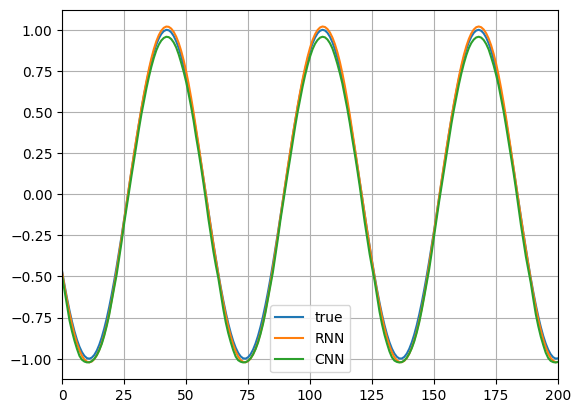

In [25]:
plt.plot(ds_sin.y_test, label='true')
plt.plot(rnn_preds, label='RNN')
plt.plot(cnn_preds, label='CNN')
plt.legend()
plt.grid()
plt.xlim(0, 200)
plt.show()

#### np.sin(x) + np.cos(x)

In [26]:
import torch.optim as optim
from torch.utils.data import DataLoader

ds_sin = FunctionDataset(total_samples, sequence_length, sin_cos_function)

train_loader = DataLoader(ds_sin.get_train_ds(), batch_size)
val_loader = DataLoader(ds_sin.get_val_ds(), batch_size)

In [27]:
net_rnn = RNN(batch_size=batch_size, input_size=input_size, hidden_size=hidden_size, num_layers=num_layers, output_size=output_size).cuda()

criterion = nn.MSELoss()
loss = nn.CrossEntropyLoss()
optimizer = optim.RMSprop(net_rnn.parameters(), lr = 0.001)

train_loss_rnn, learning_tim_rnn = train(net_rnn, train_loader, val_loader, criterion, optimizer, epochs)
print('Learning time: %.2f seconds' % learning_tim_rnn)

Print every 21 batches
[2,     6] train loss: 0.00860058, val loss 0.000949823
[3,    13] train loss: 0.00562965, val loss 0.000325452
[5,     6] train loss: 0.00161858, val loss 0.000291359
[6,    13] train loss: 0.00230928, val loss 0.000136684
[8,     6] train loss: 0.000916285, val loss 0.000156776
[9,    13] train loss: 0.0496147, val loss 0.000433114
[11,     6] train loss: 0.00212278, val loss 0.000335841
[12,    13] train loss: 0.00390812, val loss 0.000277228
[14,     6] train loss: 0.00146465, val loss 0.000233062
[15,    13] train loss: 0.00273919, val loss 0.000195141
[17,     6] train loss: 0.00103795, val loss 0.000165637
[18,    13] train loss: 0.00195765, val loss 0.000140023
[20,     6] train loss: 0.000749124, val loss 0.000119903
[21,    13] train loss: 0.00142421, val loss 0.000102298
[23,     6] train loss: 0.00055016, val loss 8.83684e-05
[24,    13] train loss: 0.00105366, val loss 7.60956e-05
[26,     6] train loss: 0.000543106, val loss 7.68464e-05
[27,    13] 

In [28]:
net_cnn = CNN(batch_size=batch_size, input_size=input_size, hidden_size=hidden_size, num_layers=num_layers, output_size=output_size).cuda()

criterion = nn.MSELoss()
loss = nn.CrossEntropyLoss()
optimizer = optim.RMSprop(net_cnn.parameters(), lr = 0.001)

train_loss_cnn, learning_time_cnn = train(net_cnn, train_loader, val_loader, criterion, optimizer, 50)
print('Learning time: %.2f seconds' % learning_time_cnn)

Print every 4 batches
[1,     3] train loss: 1.16997, val loss 0.217562
[1,     7] train loss: 0.683019, val loss 0.099652
[1,    11] train loss: 0.289861, val loss 0.0662644
[2,     1] train loss: 0.0175813, val loss 0.0100426
[2,     5] train loss: 0.0264894, val loss 0.00358332
[2,     9] train loss: 0.0122517, val loss 0.00231205
[2,    13] train loss: 0.00878049, val loss 0.00238654
[3,     3] train loss: 0.00870942, val loss 0.00324053
[3,     7] train loss: 0.00956575, val loss 0.00160432
[3,    11] train loss: 0.00432519, val loss 0.000616097
[4,     1] train loss: 0.000426314, val loss 0.000359234
[4,     5] train loss: 0.00118452, val loss 0.000225278
[4,     9] train loss: 0.000838305, val loss 0.000196886
[4,    13] train loss: 0.000784846, val loss 0.00020194
[5,     3] train loss: 0.000651382, val loss 0.000265897
[5,     7] train loss: 0.00123251, val loss 0.000472544
[5,    11] train loss: 0.00305596, val loss 0.00139983
[6,     1] train loss: 0.00186399, val loss 0.001

In [30]:
test_loader = DataLoader(ds_sin.get_test_ds(), batch_size)

rnn_test_loss, rnn_preds = test(net_rnn, test_loader, criterion)
print(f"Test loss: {rnn_test_loss / len(test_loader)}")

cnn_test_loss, cnn_preds = test(net_cnn, test_loader, criterion)
print(f"Test loss: {cnn_test_loss / len(test_loader)}")

Test loss: 0.000537119408611695
Test loss: 0.0030962785227033733


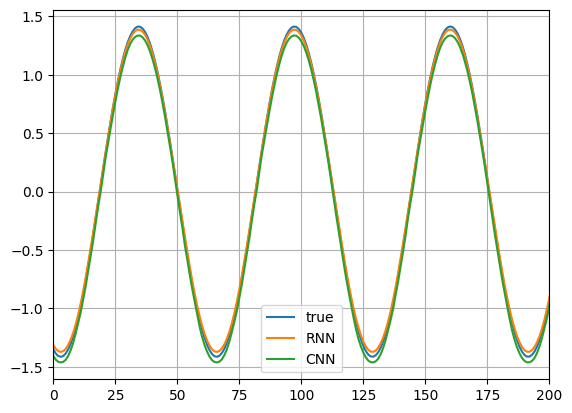

In [31]:
plt.plot(ds_sin.y_test, label='true')
plt.plot(rnn_preds, label='RNN')
plt.plot(cnn_preds, label='CNN')
plt.legend()
plt.grid()
plt.xlim(0, 200)
plt.show()

#### np.sin(2*x)

In [32]:
import torch.optim as optim
from torch.utils.data import DataLoader

ds_sin = FunctionDataset(total_samples, sequence_length, sin2x_function)

train_loader = DataLoader(ds_sin.get_train_ds(), batch_size)
val_loader = DataLoader(ds_sin.get_val_ds(), batch_size)

In [33]:
net_rnn = RNN(batch_size=batch_size, input_size=input_size, hidden_size=hidden_size, num_layers=num_layers, output_size=output_size).cuda()

criterion = nn.MSELoss()
loss = nn.CrossEntropyLoss()
optimizer = optim.RMSprop(net_rnn.parameters(), lr = 0.001)

train_loss_rnn, learning_tim_rnn = train(net_rnn, train_loader, val_loader, criterion, optimizer, epochs)
print('Learning time: %.2f seconds' % learning_tim_rnn)

Print every 21 batches
[2,     6] train loss: 0.00228543, val loss 0.000399139
[3,    13] train loss: 0.00316539, val loss 0.0001772
[5,     6] train loss: 0.000810922, val loss 0.000137453
[6,    13] train loss: 0.00161276, val loss 0.00010088
[8,     6] train loss: 0.000621844, val loss 9.25764e-05
[9,    13] train loss: 0.000903345, val loss 6.9567e-05
[11,     6] train loss: 0.000327864, val loss 5.62988e-05
[12,    13] train loss: 0.000720999, val loss 5.27893e-05
[14,     6] train loss: 0.000287325, val loss 4.72044e-05
[15,    13] train loss: 0.000525821, val loss 3.92543e-05
[17,     6] train loss: 0.00022766, val loss 4.12225e-05
[18,    13] train loss: 0.000509685, val loss 4.19983e-05
[20,     6] train loss: 0.000230162, val loss 3.75968e-05
[21,    13] train loss: 0.000464719, val loss 3.434e-05
[23,     6] train loss: 0.00020979, val loss 3.88072e-05
[24,    13] train loss: 0.000478854, val loss 3.23877e-05
[26,     6] train loss: 0.000348906, val loss 9.36563e-05
[27,    

In [34]:
net_cnn = CNN(batch_size=batch_size, input_size=input_size, hidden_size=hidden_size, num_layers=num_layers, output_size=output_size).cuda()

criterion = nn.MSELoss()
loss = nn.CrossEntropyLoss()
optimizer = optim.RMSprop(net_cnn.parameters(), lr = 0.001)

train_loss_cnn, learning_time_cnn = train(net_cnn, train_loader, val_loader, criterion, optimizer, 50)
print('Learning time: %.2f seconds' % learning_time_cnn)

Print every 4 batches
[1,     3] train loss: 0.45241, val loss 0.116351
[1,     7] train loss: 0.378288, val loss 0.0616077
[1,    11] train loss: 0.203914, val loss 0.0200524
[2,     1] train loss: 0.00551397, val loss 0.00438437
[2,     5] train loss: 0.0204633, val loss 0.00317859
[2,     9] train loss: 0.00742559, val loss 0.000677363
[2,    13] train loss: 0.00191207, val loss 0.000277894
[3,     3] train loss: 0.000760159, val loss 0.000199017
[3,     7] train loss: 0.000709006, val loss 0.000146627
[3,    11] train loss: 0.000522068, val loss 0.000113053
[4,     1] train loss: 0.000102434, val loss 0.000101295
[4,     5] train loss: 0.000414655, val loss 0.000119456
[4,     9] train loss: 0.000599732, val loss 0.000248726
[4,    13] train loss: 0.00163814, val loss 0.000786038
[5,     3] train loss: 0.0032408, val loss 0.00173149
[5,     7] train loss: 0.00783418, val loss 0.00186058
[5,    11] train loss: 0.00558454, val loss 0.000754113
[6,     1] train loss: 0.000466518, val 

In [35]:
test_loader = DataLoader(ds_sin.get_test_ds(), batch_size)

rnn_test_loss, rnn_preds = test(net_rnn, test_loader, criterion)
print(f"Test loss: {rnn_test_loss / len(test_loader)}")

cnn_test_loss, cnn_preds = test(net_cnn, test_loader, criterion)
print(f"Test loss: {cnn_test_loss / len(test_loader)}")

Test loss: 0.0003012298687033101
Test loss: 0.001914248713794884


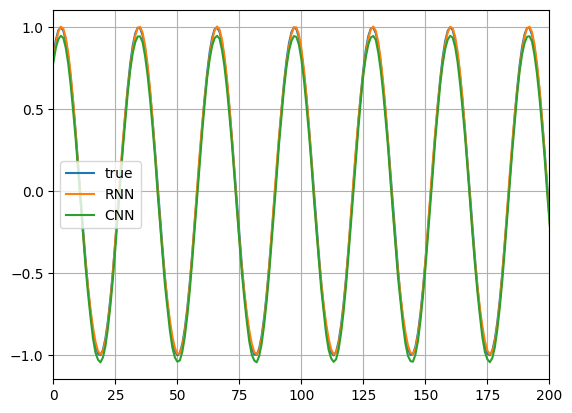

In [36]:
plt.plot(ds_sin.y_test, label='true')
plt.plot(rnn_preds, label='RNN')
plt.plot(cnn_preds, label='CNN')
plt.legend()
plt.grid()
plt.xlim(0, 200)
plt.show()

#### 2*np.sin(x) + 3*np.cos(2*x)

In [38]:
import torch.optim as optim
from torch.utils.data import DataLoader

ds_sin = FunctionDataset(total_samples, sequence_length, my_function)

train_loader = DataLoader(ds_sin.get_train_ds(), batch_size)
val_loader = DataLoader(ds_sin.get_val_ds(), batch_size)

In [39]:
net_rnn = RNN(batch_size=batch_size, input_size=input_size, hidden_size=hidden_size, num_layers=num_layers, output_size=output_size).cuda()

criterion = nn.MSELoss()
loss = nn.CrossEntropyLoss()
optimizer = optim.RMSprop(net_rnn.parameters(), lr = 0.001)

train_loss_rnn, learning_tim_rnn = train(net_rnn, train_loader, val_loader, criterion, optimizer, epochs)
print('Learning time: %.2f seconds' % learning_tim_rnn)

Print every 21 batches
[2,     6] train loss: 0.227077, val loss 0.0305412
[3,    13] train loss: 0.244325, val loss 0.0145458
[5,     6] train loss: 0.0529199, val loss 0.00793955
[6,    13] train loss: 0.086547, val loss 0.0061919
[8,     6] train loss: 0.0293272, val loss 0.0044185
[9,    13] train loss: 0.0495038, val loss 0.00337226
[11,     6] train loss: 0.0169399, val loss 0.0025823
[12,    13] train loss: 0.0296996, val loss 0.00224525
[14,     6] train loss: 0.0100645, val loss 0.00153238
[15,    13] train loss: 0.016946, val loss 0.00111243
[17,     6] train loss: 0.00567365, val loss 0.000850465
[18,    13] train loss: 0.00914573, val loss 0.000587549
[20,     6] train loss: 0.00408554, val loss 0.000600534
[21,    13] train loss: 0.00447572, val loss 0.00029299
[23,     6] train loss: 0.00190192, val loss 0.000287128
[24,    13] train loss: 0.00336861, val loss 0.000295763
[26,     6] train loss: 0.000768737, val loss 0.000129229
[27,    13] train loss: 0.00465244, val los

In [40]:
net_cnn = CNN(batch_size=batch_size, input_size=input_size, hidden_size=hidden_size, num_layers=num_layers, output_size=output_size).cuda()

criterion = nn.MSELoss()
loss = nn.CrossEntropyLoss()
optimizer = optim.RMSprop(net_cnn.parameters(), lr = 0.001)

train_loss_cnn, learning_time_cnn = train(net_cnn, train_loader, val_loader, criterion, optimizer, 50)
print('Learning time: %.2f seconds' % learning_time_cnn)

Print every 4 batches
[1,     3] train loss: 6.48146, val loss 1.4269
[1,     7] train loss: 4.78699, val loss 0.935218
[1,    11] train loss: 3.76322, val loss 0.431911
[2,     1] train loss: 0.192545, val loss 0.123694
[2,     5] train loss: 0.464932, val loss 0.40425
[2,     9] train loss: 1.06171, val loss 0.034938
[2,    13] train loss: 0.11007, val loss 0.0205492
[3,     3] train loss: 0.0582259, val loss 0.0168007
[3,     7] train loss: 0.0623614, val loss 0.012875
[3,    11] train loss: 0.0460933, val loss 0.00966787
[4,     1] train loss: 0.00874837, val loss 0.00813024
[4,     5] train loss: 0.0316404, val loss 0.00788486
[4,     9] train loss: 0.0302333, val loss 0.00723513
[4,    13] train loss: 0.0288137, val loss 0.00619246
[5,     3] train loss: 0.0176984, val loss 0.00519637
[5,     7] train loss: 0.0194714, val loss 0.00454165
[5,    11] train loss: 0.0176782, val loss 0.00424035
[6,     1] train loss: 0.00455272, val loss 0.0045954
[6,     5] train loss: 0.0191477, va

In [41]:
test_loader = DataLoader(ds_sin.get_test_ds(), batch_size)

rnn_test_loss, rnn_preds = test(net_rnn, test_loader, criterion)
print(f"Test loss: {rnn_test_loss / len(test_loader)}")

cnn_test_loss, cnn_preds = test(net_cnn, test_loader, criterion)
print(f"Test loss: {cnn_test_loss / len(test_loader)}")

Test loss: 0.001077914025782692
Test loss: 0.014426550663880666


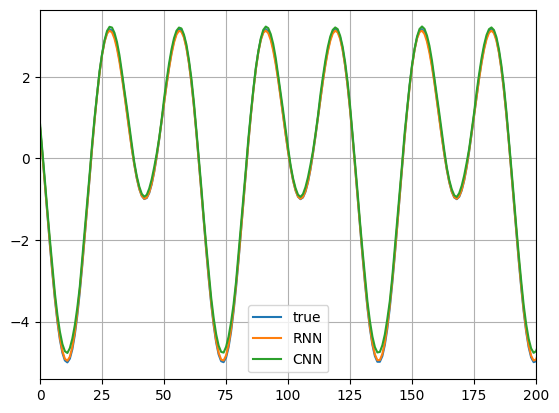

In [42]:
plt.plot(ds_sin.y_test, label='true')
plt.plot(rnn_preds, label='RNN')
plt.plot(cnn_preds, label='CNN')
plt.legend()
plt.grid()
plt.xlim(0, 200)
plt.show()

### Exp 2

In [45]:
import gc
gc.collect()

530

In [81]:
def rastragin_function(x: np.ndarray):
    A = 10
    return A + np.sum(x**2 - A * np.cos(2 * np.pi * x))

def ackley_function(x):
    a = 20
    b = 0.2
    c = 2 * np.pi
    d = len(x)
    sum1 = -a * np.exp(-b * np.sqrt(1/d * np.sum(x**2)))
    sum2 = -np.exp(1/d * np.sum(np.cos(c*x)))
    return sum1 + sum2 + a + np.exp(1)

def rosenbrock_function(x):
    return np.sum(100 * (x[1:] - x[:-1]**2)**2 + (1 - x[:-1])**2)

In [79]:
from torch.utils.data import Dataset
import torch

class FunctionDataset:
    class SequenceDs(Dataset):
        def __init__(self, X, y) -> None:
            super().__init__()
            self.X = X
            self.y = y

        def __len__(self):
            return len(self.y)
        
        def __getitem__(self, index) -> tuple[torch.Tensor, torch.Tensor]:
            return torch.tensor(self.X[index]).float(), torch.tensor(self.y[index]).float()

    def __init__(self, total_samples, sequence_length, fn):
        self.total_samples = total_samples
        self.sequence_length = sequence_length

        self.x_f = np.linspace(-5.12, 5.12, 20_000 + 100)
        self.y_f = [fn(x) for x in self.generate_sequence(self.x_f, 100)[0]]

        plt.plot(self.y_f)
        plt.show()

        X, y = self.generate_sequence(self.y_f, self.sequence_length)

        print(len(X), len(y))

        # split into train, validation and test set
        self.X = X[:int(total_samples * 0.7)]
        self.X_val = X[int(total_samples * 0.7):int(total_samples * 0.8)]
        self.X_test = X[int(total_samples * 0.8):]

        self.y = y[:int(total_samples * 0.7)]
        self.y_val = y[int(total_samples * 0.7):int(total_samples * 0.8)]
        self.y_test = y[int(total_samples * 0.8):]

        print(len(self.X_test), len(self.y_test))


    def generate_sequence(self, y, l):
        X_seq = []
        y_seq = []
        for i in range(len(y) - l):
            X_seq.append(y[i:i+l])
            y_seq.append(y[i+l])
        return np.array(X_seq), np.array(y_seq)

    def get_train_ds(self):
        return self.SequenceDs(self.X, self.y)
    
    def get_val_ds(self):
        return self.SequenceDs(self.X_val, self.y_val)
    
    def get_test_ds(self):
        return self.SequenceDs(self.X_test, self.y_test)

#### rastragin_function

20000


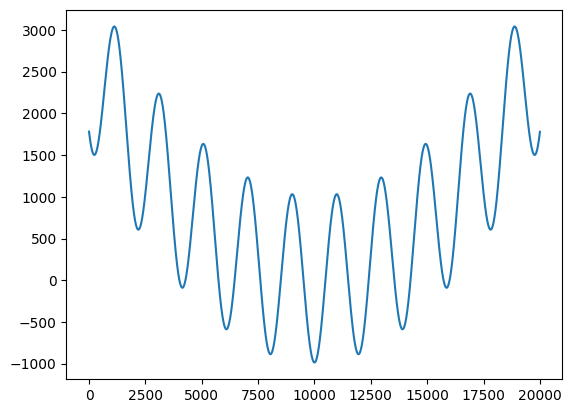

19000 19000
15000 15000


In [73]:
import torch.optim as optim
from torch.utils.data import DataLoader

ds = FunctionDataset(total_samples, sequence_length, rastragin_function)

train_loader = DataLoader(ds.get_train_ds(), batch_size)
val_loader = DataLoader(ds.get_val_ds(), batch_size)
test_loader = DataLoader(ds.get_test_ds(), batch_size)

In [74]:
net_rnn = RNN(batch_size=batch_size, input_size=input_size, hidden_size=hidden_size, num_layers=num_layers, output_size=output_size).cuda()

criterion = nn.MSELoss()
loss = nn.CrossEntropyLoss()
optimizer = optim.RMSprop(net_rnn.parameters(), lr = 0.001)

train_loss_rnn, learning_tim_rnn = train(net_rnn, train_loader, val_loader, criterion, optimizer, 1_000)
print('Learning time: %.2f seconds' % learning_tim_rnn)

Print every 70 batches
[5,    13] train loss: 527975, val loss 10497.2
[10,    13] train loss: 526478, val loss 10432
[15,    13] train loss: 525201, val loss 10375.5
[20,    13] train loss: 524005, val loss 10322.2
[25,    13] train loss: 522848, val loss 10270.6
[30,    13] train loss: 521709, val loss 10219.8
[35,    13] train loss: 520581, val loss 10169.4
[40,    13] train loss: 519459, val loss 10119.4
[45,    13] train loss: 518341, val loss 10069.7
[50,    13] train loss: 517225, val loss 10020.1
[55,    13] train loss: 516112, val loss 9970.61
[60,    13] train loss: 515001, val loss 9921.31
[65,    13] train loss: 513892, val loss 9872.15
[70,    13] train loss: 512785, val loss 9823.12
[75,    13] train loss: 511679, val loss 9774.23
[80,    13] train loss: 510575, val loss 9725.47
[85,    13] train loss: 509472, val loss 9676.84
[90,    13] train loss: 508372, val loss 9628.35
[95,    13] train loss: 507273, val loss 9579.98
[100,    13] train loss: 506175, val loss 9531.75

In [75]:
net_cnn = CNN(batch_size=batch_size, input_size=input_size, hidden_size=hidden_size, num_layers=num_layers, output_size=output_size).cuda()

criterion = nn.MSELoss()
loss = nn.CrossEntropyLoss()
optimizer = optim.RMSprop(net_cnn.parameters(), lr = 0.001)

train_loss_cnn, learning_time_cnn = train(net_cnn, train_loader, val_loader, criterion, optimizer, 100)
print('Learning time: %.2f seconds' % learning_time_cnn)

Print every 7 batches
[1,     6] train loss: 1.90872e+06, val loss 47587.3
[1,    13] train loss: 580154, val loss 55607.2
[2,     6] train loss: 943279, val loss 6261.83
[2,    13] train loss: 70557.6, val loss 49271.4
[3,     6] train loss: 465945, val loss 10781.4
[3,    13] train loss: 53552.7, val loss 19802.5
[4,     6] train loss: 51016.3, val loss 20792.2
[4,    13] train loss: 31852.2, val loss 6484.15
[5,     6] train loss: 31081.7, val loss 6982.45
[5,    13] train loss: 15723.3, val loss 1836.25
[6,     6] train loss: 21786.9, val loss 1825.11
[6,    13] train loss: 15773.7, val loss 6217.92
[7,     6] train loss: 47195.1, val loss 6156.87
[7,    13] train loss: 17592.7, val loss 1678.18
[8,     6] train loss: 13635.6, val loss 1935.76
[8,    13] train loss: 8543.71, val loss 1552.72
[9,     6] train loss: 13819.3, val loss 2031.26
[9,    13] train loss: 7303.16, val loss 475.131
[10,     6] train loss: 12413.6, val loss 511.013
[10,    13] train loss: 9754.81, val loss 135

In [77]:
test_loader = DataLoader(ds.get_test_ds(), batch_size)

rnn_test_loss, rnn_preds = test(net_rnn, test_loader, criterion)
print(f"Test loss: {rnn_test_loss / len(test_loader)}")

cnn_test_loss, cnn_preds = test(net_cnn, test_loader, criterion)
print(f"Test loss: {cnn_test_loss / len(test_loader)}")

Test loss: 746406.1026472641
Test loss: 2482.1852314835887


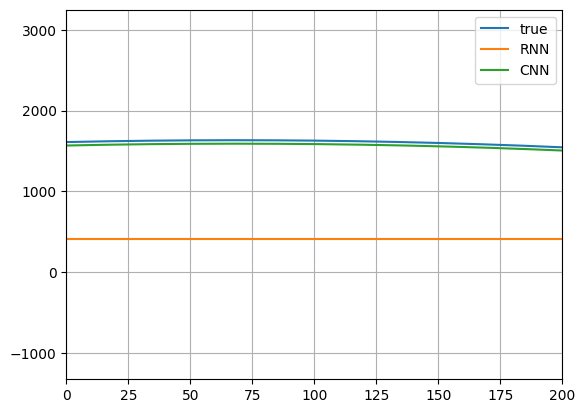

In [78]:
plt.plot(ds.y_test, label='true')
plt.plot(rnn_preds, label='RNN')
plt.plot(cnn_preds, label='CNN')
plt.legend()
plt.grid()
plt.xlim(0, 200)
plt.show()

#### ackley_function

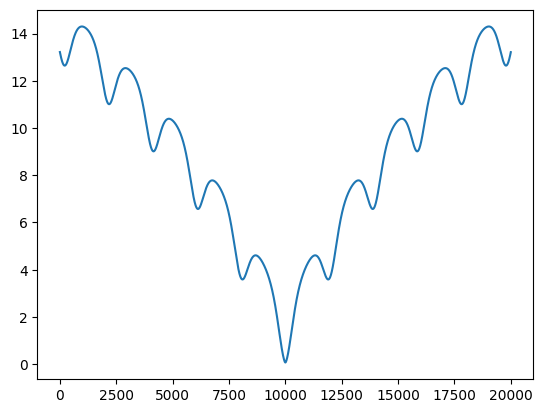

19000 19000
15000 15000


In [82]:
import torch.optim as optim
from torch.utils.data import DataLoader

ds = FunctionDataset(total_samples, sequence_length, ackley_function)

train_loader = DataLoader(ds.get_train_ds(), batch_size)
val_loader = DataLoader(ds.get_val_ds(), batch_size)
test_loader = DataLoader(ds.get_test_ds(), batch_size)

In [83]:
net_rnn = RNN(batch_size=batch_size, input_size=input_size, hidden_size=hidden_size, num_layers=num_layers, output_size=output_size).cuda()

criterion = nn.MSELoss()
loss = nn.CrossEntropyLoss()
optimizer = optim.RMSprop(net_rnn.parameters(), lr = 0.001)

train_loss_rnn, learning_tim_rnn = train(net_rnn, train_loader, val_loader, criterion, optimizer, 1_000)
print('Learning time: %.2f seconds' % learning_tim_rnn)

Print every 70 batches
[5,    13] train loss: 5.19559, val loss 0.127003
[10,    13] train loss: 1.39846, val loss 0.00280642
[15,    13] train loss: 0.517905, val loss 0.0159543
[20,    13] train loss: 0.406359, val loss 0.036521
[25,    13] train loss: 0.389643, val loss 0.0364024
[30,    13] train loss: 0.306782, val loss 0.0133345
[35,    13] train loss: 0.238992, val loss 0.00737836
[40,    13] train loss: 0.174496, val loss 0.00119065
[45,    13] train loss: 0.106259, val loss 0.00233677
[50,    13] train loss: 0.0649811, val loss 0.000620794
[55,    13] train loss: 0.048035, val loss 1.23385e-05
[60,    13] train loss: 0.0325103, val loss 0.000608494
[65,    13] train loss: 0.0169339, val loss 0.00019106
[70,    13] train loss: 0.0143678, val loss 0.000278833
[75,    13] train loss: 0.0114707, val loss 0.00045994
[80,    13] train loss: 0.0106379, val loss 0.000637086
[85,    13] train loss: 0.00938298, val loss 0.000144807
[90,    13] train loss: 0.00459334, val loss 0.00069077

In [84]:
net_cnn = CNN(batch_size=batch_size, input_size=input_size, hidden_size=hidden_size, num_layers=num_layers, output_size=output_size).cuda()

criterion = nn.MSELoss()
loss = nn.CrossEntropyLoss()
optimizer = optim.RMSprop(net_cnn.parameters(), lr = 0.001)

train_loss_cnn, learning_time_cnn = train(net_cnn, train_loader, val_loader, criterion, optimizer, 100)
print('Learning time: %.2f seconds' % learning_time_cnn)

Print every 7 batches
[1,     6] train loss: 72.6981, val loss 3.27
[1,    13] train loss: 12.228, val loss 0.0449078
[2,     6] train loss: 6.15871, val loss 0.0392458
[2,    13] train loss: 3.67936, val loss 0.966596
[3,     6] train loss: 4.99812, val loss 0.298692
[3,    13] train loss: 1.49859, val loss 0.0643569
[4,     6] train loss: 2.04406, val loss 0.0494989
[4,    13] train loss: 2.10589, val loss 0.225931
[5,     6] train loss: 2.38676, val loss 0.226119
[5,    13] train loss: 1.30544, val loss 0.0673379
[6,     6] train loss: 0.997668, val loss 0.382107
[6,    13] train loss: 1.45768, val loss 0.0109849
[7,     6] train loss: 1.27755, val loss 0.0128868
[7,    13] train loss: 1.03069, val loss 0.348562
[8,     6] train loss: 1.72651, val loss 0.347394
[8,    13] train loss: 1.18193, val loss 0.0182466
[9,     6] train loss: 0.992437, val loss 0.0215468
[9,    13] train loss: 0.707424, val loss 0.343782
[10,     6] train loss: 1.6945, val loss 0.102027
[10,    13] train los

In [85]:
test_loader = DataLoader(ds.get_test_ds(), batch_size)

rnn_test_loss, rnn_preds = test(net_rnn, test_loader, criterion)
print(f"Test loss: {rnn_test_loss / len(test_loader)}")

cnn_test_loss, cnn_preds = test(net_cnn, test_loader, criterion)
print(f"Test loss: {cnn_test_loss / len(test_loader)}")

Test loss: 2.1613072543935896
Test loss: 0.4296822236116849


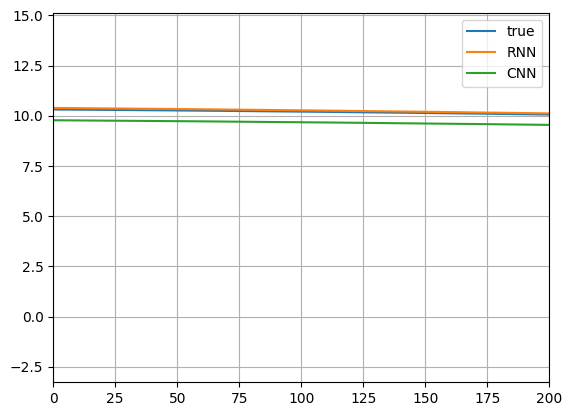

In [86]:
plt.plot(ds.y_test, label='true')
plt.plot(rnn_preds, label='RNN')
plt.plot(cnn_preds, label='CNN')
plt.legend()
plt.grid()
plt.xlim(0, 200)
plt.show()

#### rosenbrock_function

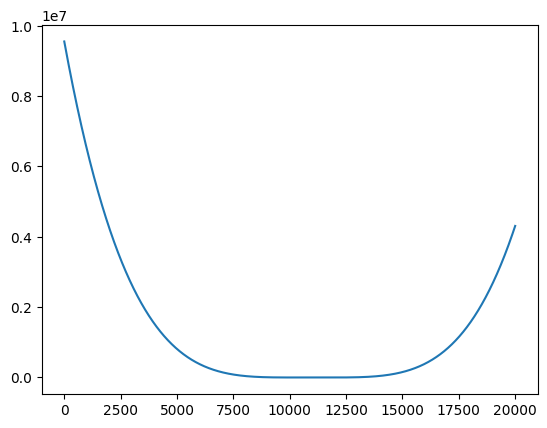

19000 19000
15000 15000


In [87]:
import torch.optim as optim
from torch.utils.data import DataLoader

ds = FunctionDataset(total_samples, sequence_length, rosenbrock_function)

train_loader = DataLoader(ds.get_train_ds(), batch_size)
val_loader = DataLoader(ds.get_val_ds(), batch_size)
test_loader = DataLoader(ds.get_test_ds(), batch_size)

In [88]:
net_rnn = RNN(batch_size=batch_size, input_size=input_size, hidden_size=hidden_size, num_layers=num_layers, output_size=output_size).cuda()

criterion = nn.MSELoss()
loss = nn.CrossEntropyLoss()
optimizer = optim.RMSprop(net_rnn.parameters(), lr = 0.001)

train_loss_rnn, learning_tim_rnn = train(net_rnn, train_loader, val_loader, criterion, optimizer, 1_000)
print('Learning time: %.2f seconds' % learning_tim_rnn)

Print every 70 batches
[5,    13] train loss: 2.52306e+12, val loss 1.54428e+10
[10,    13] train loss: 2.52306e+12, val loss 1.54427e+10
[15,    13] train loss: 2.52305e+12, val loss 1.54426e+10
[20,    13] train loss: 2.52305e+12, val loss 1.54425e+10
[25,    13] train loss: 2.52305e+12, val loss 1.54425e+10
[30,    13] train loss: 2.52305e+12, val loss 1.54424e+10
[35,    13] train loss: 2.52304e+12, val loss 1.54424e+10
[40,    13] train loss: 2.52304e+12, val loss 1.54423e+10
[45,    13] train loss: 2.52304e+12, val loss 1.54422e+10
[50,    13] train loss: 2.52303e+12, val loss 1.54422e+10
[55,    13] train loss: 2.52303e+12, val loss 1.54421e+10
[60,    13] train loss: 2.52303e+12, val loss 1.5442e+10
[65,    13] train loss: 2.52303e+12, val loss 1.5442e+10
[70,    13] train loss: 2.52302e+12, val loss 1.54419e+10
[75,    13] train loss: 2.52302e+12, val loss 1.54418e+10
[80,    13] train loss: 2.52302e+12, val loss 1.54418e+10
[85,    13] train loss: 2.52302e+12, val loss 1.5441

In [89]:
net_cnn = CNN(batch_size=batch_size, input_size=input_size, hidden_size=hidden_size, num_layers=num_layers, output_size=output_size).cuda()

criterion = nn.MSELoss()
loss = nn.CrossEntropyLoss()
optimizer = optim.RMSprop(net_cnn.parameters(), lr = 0.001)

train_loss_cnn, learning_time_cnn = train(net_cnn, train_loader, val_loader, criterion, optimizer, 100)
print('Learning time: %.2f seconds' % learning_time_cnn)

Print every 7 batches
[1,     6] train loss: 9.79501e+12, val loss 9.62396e+10
[1,    13] train loss: 6.63474e+11, val loss 2.16894e+08
[2,     6] train loss: 5.85691e+11, val loss 4.66149e+08
[2,    13] train loss: 1.44394e+11, val loss 5.07676e+09
[3,     6] train loss: 7.15427e+11, val loss 1.54357e+10
[3,    13] train loss: 1.06827e+11, val loss 6.13528e+08
[4,     6] train loss: 1.98844e+11, val loss 6.42675e+08
[4,    13] train loss: 5.61576e+10, val loss 1.96194e+09
[5,     6] train loss: 4.46657e+11, val loss 9.47002e+09
[5,    13] train loss: 5.3413e+10, val loss 5.42355e+08
[6,     6] train loss: 1.39539e+11, val loss 5.21502e+08
[6,    13] train loss: 3.90144e+10, val loss 1.25978e+09
[7,     6] train loss: 3.76099e+11, val loss 7.06998e+09
[7,    13] train loss: 3.46643e+10, val loss 4.51725e+08
[8,     6] train loss: 1.25233e+11, val loss 4.26269e+08
[8,    13] train loss: 2.89207e+10, val loss 1.01254e+09
[9,     6] train loss: 3.51594e+11, val loss 5.63834e+09
[9,    13]

In [90]:
test_loader = DataLoader(ds.get_test_ds(), batch_size)

rnn_test_loss, rnn_preds = test(net_rnn, test_loader, criterion)
print(f"Test loss: {rnn_test_loss / len(test_loader)}")

cnn_test_loss, cnn_preds = test(net_cnn, test_loader, criterion)
print(f"Test loss: {cnn_test_loss / len(test_loader)}")

Test loss: 1068052114572.4541
Test loss: 90413435859.37766


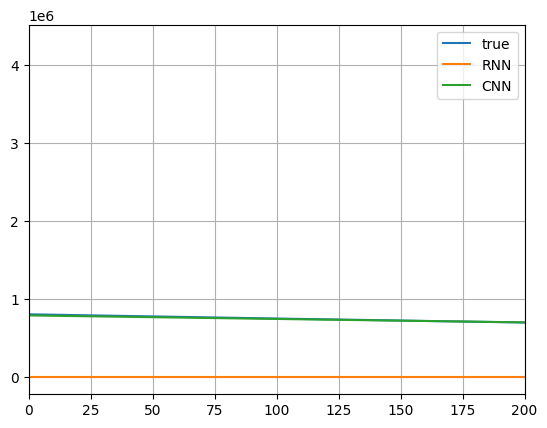

In [91]:
plt.plot(ds.y_test, label='true')
plt.plot(rnn_preds, label='RNN')
plt.plot(cnn_preds, label='CNN')
plt.legend()
plt.grid()
plt.xlim(0, 200)
plt.show()

### Exp 3

In [92]:
def rastrigin(x, y):
    return 20 + (x**2 - 10 * np.cos(2*np.pi*x)) + (y**2 - 10 * np.cos(2*np.pi*y))

def ackley(x, y):
    return -20 * np.exp(-0.2 * np.sqrt(0.5*(x**2 + y**2))) - np.exp(0.5*(np.cos(2*np.pi*x) + np.cos(2*np.pi*y))) + 20 + np.e

def booth(x, y):
    return (x + 2*y - 7)**2 + (2*x + y - 5)**2
